In [1]:
import pandas as pd
import re
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from openTSNE import TSNE

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches

### Get data

In [7]:
df = pd.read_csv("data/topics_df.csv")
all_info = pd.read_csv("/home/sarah/projects/nets/data/wos_scopus_all.csv")
tech = pd.read_csv("/home/sarah/projects/nets_climatebert/data/2023-03-25_tech_predicted_unbalanced.csv")
allClasses = [i.split('pred_')[1] for i in tech.columns if 'pred_' in i]

def get_highest_prob(row):
    high_prob = 0
    cl = allClasses[0]    
    for c in allClasses:
        if row['predProba_'+c]>high_prob:
            high_prob = row['predProba_'+c]
            cl = c
    return cl

tech['first_pred_tech'] = tech.apply(get_highest_prob, axis=1)

df = df.merge(all_info[["id","title","abstract", "year"]], how="left", on="id")
df = df.merge(tech[['id']+[i for i in tech.columns if 'pred_' in i]+[i for i in tech.columns if 'predProba_' in i]], how="left", on='id')

# no tech prediction
df = df.dropna(subset="first_pred_tech")

In [8]:
df["num_tech"] = df[['pred_Forest Management',
 'pred_Other technologies',
 'pred_restoration of landscapes/peats',
 'pred_Algae farming',
 'pred_Blue Carbon',
 'pred_Agroforestry',
 'pred_AR',
 'pred_Biochar',
 'pred_CCUS',
 'pred_DAC(CS)',
 'pred_BECCS',
 'pred_Enhanced Weathering (land based)',
 'pred_Soil Carbon Sequestration',
 'pred_General Literature on CDR/NET',
 'pred_Ocean alkalinity enhancement',
 'pred_Ocean fertilization & Artificial upwelling']].apply(sum, axis=1)

In [9]:
# deduplicate

def make_tslug(s):
    if s is not None:
        return re.sub('\W','',s).lower()
    else:
        return None

df = df.dropna(subset="title")    
df["tslug"] = df.title.apply(make_tslug)
print(df.shape)
print(df.drop_duplicates(subset="tslug").shape)

df = df.drop_duplicates(subset="tslug")
df["title_abstract"] = df["title"] + df["abstract"]

df = df.dropna(subset="title_abstract")
print(df.shape)

(22147, 171)
(22147, 171)
(22142, 172)


### Calculate tsne

In [11]:
vectorizer = TfidfVectorizer(stop_words='english') 
tfidf_text = vectorizer.fit_transform(df["title_abstract"])

In [27]:
pca = TruncatedSVD(n_components=50)
pca_result = pca.fit_transform(tfidf_text)
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
tsne_fit = tsne.fit(pca_result)

--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 3.58 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.34 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.16 seconds
===> Running optimization with exaggeration=12.00, lr=1852.08 for 250 iterations...
Iteration   50, KL divergence 5.5617, 50 iterations in 1.5776 sec
Iteration  100, KL divergence 5.3639, 50 iterations in 1.9304 sec
Iteration  150, KL divergence 5.3562, 50 iterations in 2.1333 sec
Iteration  200, KL divergence 5.3557, 50 iterations in 2.2357 sec
Iteration  250, KL divergence 5.3557, 50 iterations in 2.1924 sec
   --> Time elapsed: 10.07 seconds
===> Running optimization with exaggeration=1.00, lr=1852.08 for 50

In [28]:
df["tsne_x"] = list(tsne_fit[:,0])
df["tsne_y"] = list(tsne_fit[:,1])

df.to_csv("data/topics_tsne.csv", index=False)

In [15]:
tech_goodOrder = [
    "CCS",
    "BECCS",
    "DAC(CS)",
    "CCUS",
  
    "Soil Carbon Sequestration",
    "AR",
    "restoration of landscapes/peats",
    "Agroforestry",
    "Forest Management",
    
    "Biochar",
    
    "Enhanced Weathering (land based)",
    
    "Ocean alkalinity enhancement",
    "Blue Carbon",
    "Algae farming",
    "Ocean fertilization & Artificial upwelling",
    
    "General Literature on CDR/NET",
    "Other technologies",
]

col_ccs = ['#fdae6b','#fc8d59','#e6550d','#d7301f']# oranges
col_ccs.reverse() 

col_landbased = ['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c'] # greens
col_landbased.reverse() 

col_biochar =  ['#f768a1'] # violet

col_ew_landbased =  ['#c994c7'] # bright violet
col_ocean = ['#f1eef6','#bdc9e1','#74a9cf','#0570b0'] # blues
col_gen_other = ['#636363', '#bdbdbd'] # greys

color_tech = (
             col_ccs + 
             col_landbased +  
             col_biochar + 
             col_ew_landbased + 
             col_ocean +
             col_gen_other
)

tc = {}
for i, tech in enumerate(tech_goodOrder):
    tc[tech]=color_tech[i]
df["tech_color"] = df.first_pred_tech.replace(tc)

### Scatterplot

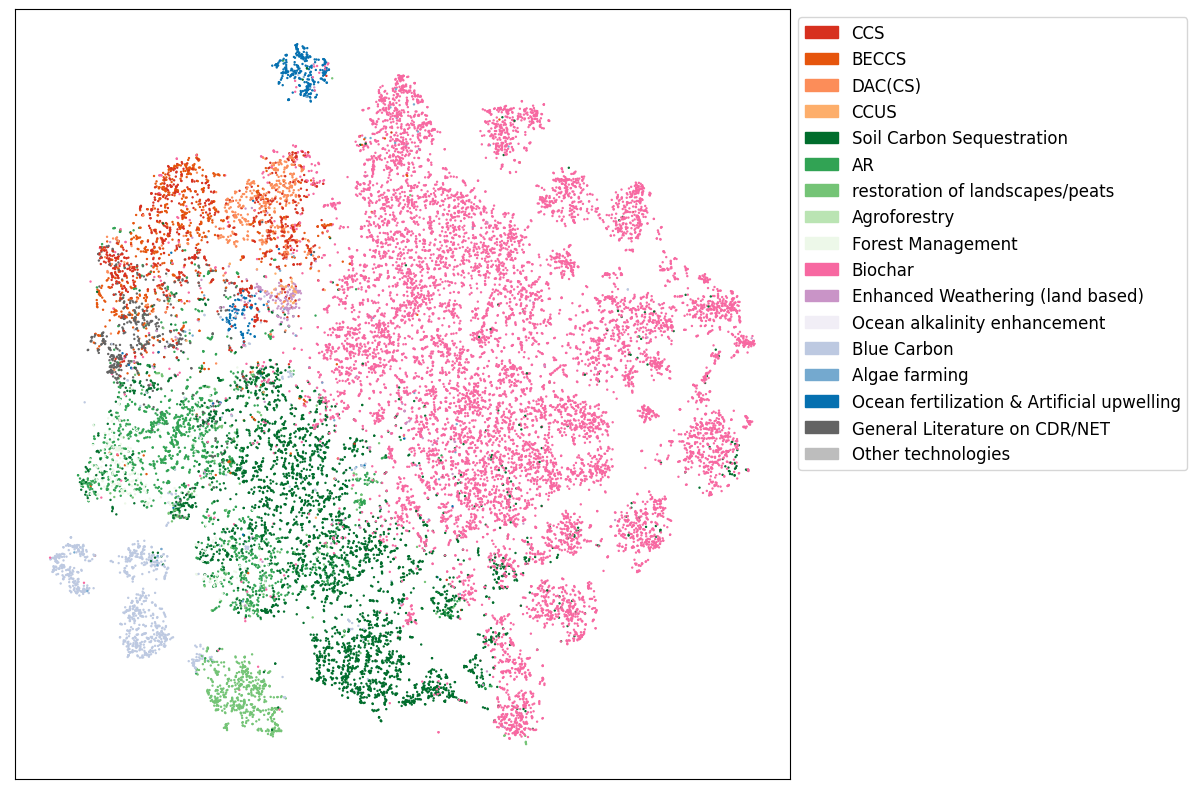

In [30]:
## complete with predicted tech
fig, ax = plt.subplots(figsize=(10,10))

#plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])

_ = ax.scatter(df.tsne_x, df.tsne_y, s=0.5, c=df.tech_color)

legend_labels = []
for t in tech_goodOrder:
    legend_labels.append(mpatches.Patch(color=tc[t], label=t))
plt.legend(handles=legend_labels, bbox_to_anchor=(1,1), fontsize=12)
fig.savefig("figures/map_techs.png", bbox_inches="tight", facecolor='white', edgecolor='none')

### Scatterplot with topics

In [57]:
from sklearn.cluster import KMeans
#tsne_x = np.array([xi for xi in dfs['tsne'].values])
kmeans = KMeans(n_clusters=40, random_state=0).fit(df[["tsne_x","tsne_y"]])
classes = np.unique(kmeans.labels_)
print(kmeans.labels_)
#print(kmeans.cluster_centers_)

[34 25 34 ... 14 16 15]


In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
cluster_titles = ['' for _ in classes]
for li, ll in enumerate(kmeans.labels_):
    tit = df.iloc[li]['title']
    if tit is not None:
        cluster_titles[ll] += tit

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3), min_df=1, max_df=0.6, strip_accents='ascii')
vectors = vectorizer.fit_transform(cluster_titles)
iv = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_keywords = [
    iv[kwi[0]]
    for kwi in vectors.argmax(axis=1).tolist()
]

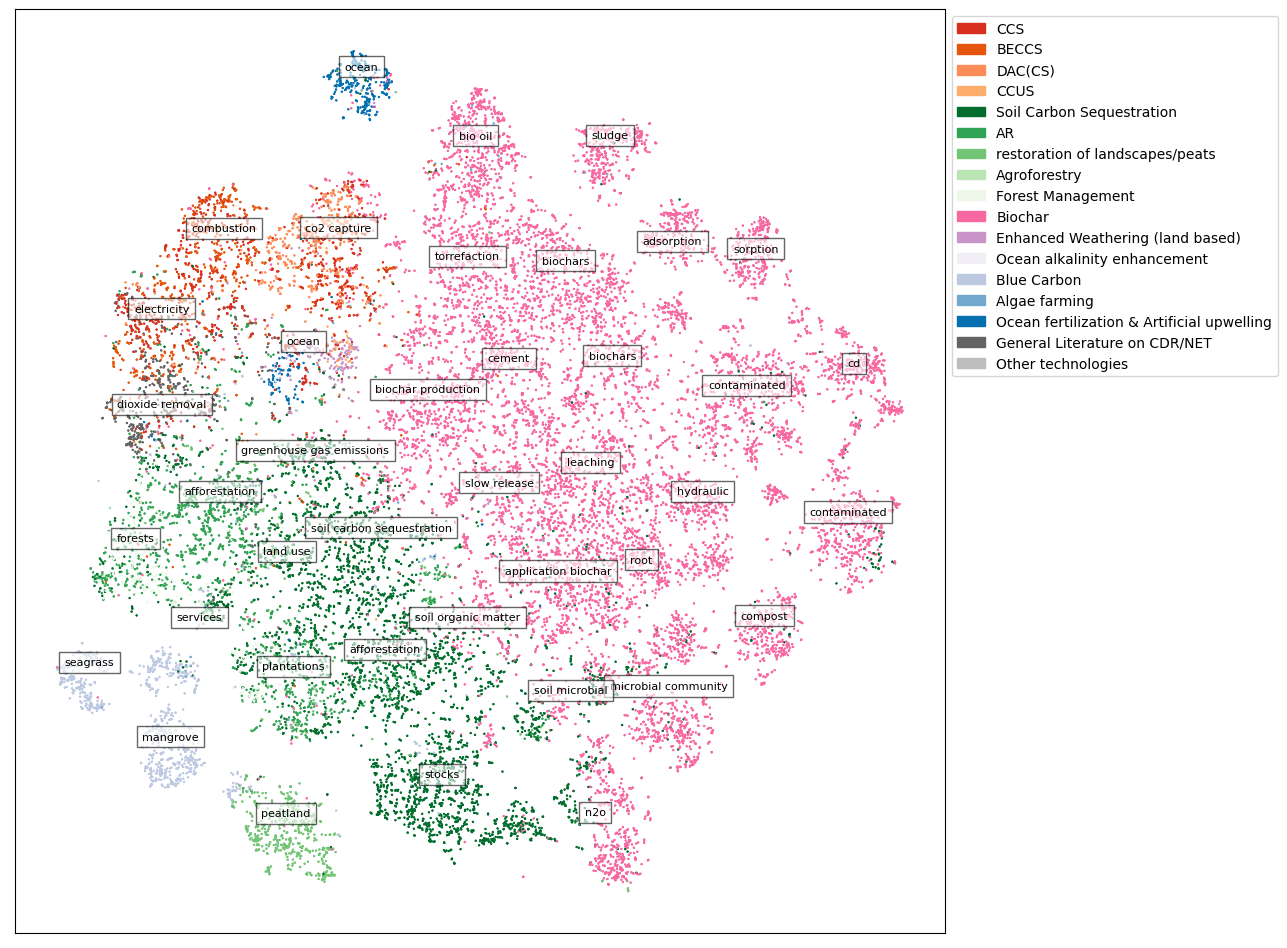

In [59]:
import matplotlib
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
scatter = ax.scatter(df.tsne_x, df.tsne_y, s=0.2, c=df.tech_color)

sizemap = {0: 1, 1: 10, 2: 10, 3: 20}
_ = ax.scatter(df.tsne_x, df.tsne_y, s=0.5, c=df.tech_color, rasterized=True)

#center_colors = list(map(colors.get, classes))
#ax.scatter(
#    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="black", s=48, alpha=1, edgecolor='k'
#)

# Draw mediod labels
for idx, label in enumerate(cluster_keywords):
    ax.text(
        kmeans.cluster_centers_[idx, 0],
        kmeans.cluster_centers_[idx, 1] + 2.2,
        label,
        fontsize=8,
        horizontalalignment="center",
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='black')
    )

# Hide ticks and axis
ax.set_xticks([]), ax.set_yticks([])#, ax.axis("off")

# legend
techs_con = df.first_pred_tech.unique().tolist()
#techs_goodOrder = [t for t in tech_goodOrder if t in techs_con]
legend_labels = []
for t in tech_goodOrder:
    legend_labels.append(mpatches.Patch(color=tc[t], label=t))
plt.legend(handles=legend_labels, bbox_to_anchor=(1,1))
fig.savefig('figures/map_techs_topic_tfidf_40cluster.png', bbox_inches="tight", facecolor='white', edgecolor='none')

### Time Development

In [13]:
vectorizer = TfidfVectorizer(stop_words='english') 
tfidf_text = vectorizer.fit_transform(df["title_abstract"])

pca = TruncatedSVD(n_components=50)
pca_result = pca.fit_transform(tfidf_text)
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
tsne_fit = tsne.fit(pca_result)

df["tsne_x"] = list(tsne_fit[:,0])
df["tsne_y"] = list(tsne_fit[:,1])

--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 4.35 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.41 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.15 seconds
===> Running optimization with exaggeration=12.00, lr=1845.17 for 250 iterations...
Iteration   50, KL divergence 5.5602, 50 iterations in 1.9866 sec
Iteration  100, KL divergence 5.3644, 50 iterations in 1.9154 sec
Iteration  150, KL divergence 5.3569, 50 iterations in 1.8916 sec
Iteration  200, KL divergence 5.3564, 50 iterations in 2.0038 sec
Iteration  250, KL divergence 5.3564, 50 iterations in 1.9802 sec
   --> Time elapsed: 9.78 seconds
===> Running optimization with exaggeration=1.00, lr=1845.17 for 500

In [18]:
df_lessOrEq_2010 = df.loc[df.year<=2010]

vectorizer = TfidfVectorizer(stop_words='english') 
tfidf_text = vectorizer.fit_transform(df_lessOrEq_2010["title_abstract"])

pca = TruncatedSVD(n_components=50)
pca_result = pca.fit_transform(tfidf_text)
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
tsne_fit = tsne.fit(pca_result)

df_lessOrEq_2010["tsne_x"] = list(tsne_fit[:,0])
df_lessOrEq_2010["tsne_y"] = list(tsne_fit[:,1])

--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.33 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.05 seconds
===> Running optimization with exaggeration=12.00, lr=216.17 for 250 iterations...
Iteration   50, KL divergence 3.9635, 50 iterations in 0.4333 sec
Iteration  100, KL divergence 3.7912, 50 iterations in 0.2492 sec
Iteration  150, KL divergence 3.7881, 50 iterations in 0.2303 sec
Iteration  200, KL divergence 3.7824, 50 iterations in 0.2294 sec
Iteration  250, KL divergence 3.7787, 50 iterations in 0.2395 sec
   --> Time elapsed: 1.38 seconds
===> Running optimization with exaggeration=1.00, lr=216.17 for 500 i

/tmp/ipykernel_264195/169730802.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lessOrEq_2010["tsne_x"] = list(tsne_fit[:,0])
/tmp/ipykernel_264195/169730802.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lessOrEq_2010["tsne_y"] = list(tsne_fit[:,1])


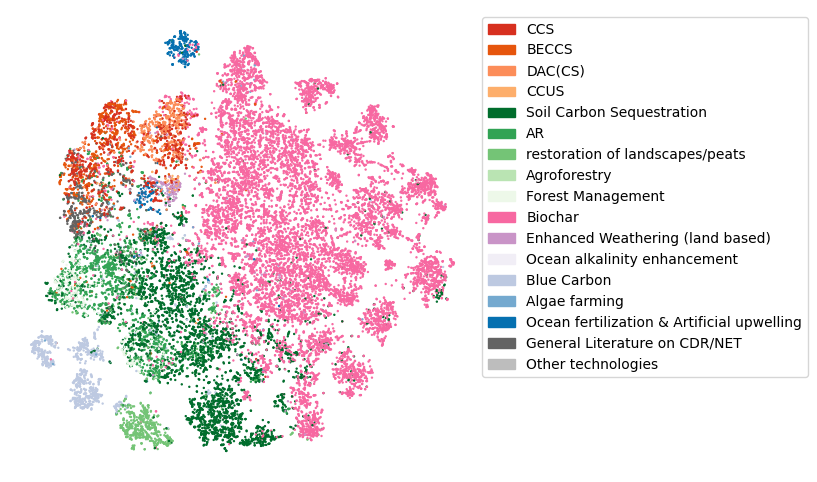

In [50]:
## complete with predicted tech
fig, ax = plt.subplots(figsize=(6,6))

ax.axis('off')

#plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])

_ = ax.scatter(df.tsne_x, df.tsne_y, s=0.5, c=df.tech_color)

legend_labels = []
for t in tech_goodOrder:
    legend_labels.append(mpatches.Patch(color=tc[t], label=t))
plt.legend(handles=legend_labels, bbox_to_anchor=(1,1), fontsize=10)
fig.savefig("/home/sarah/projects/living_evidence/figures/complete_map.png", bbox_inches="tight", facecolor='white', edgecolor='none')

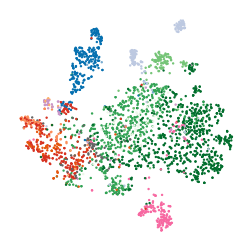

In [51]:
fig, ax = plt.subplots(figsize=(3,3))


ax.axis('off')

#plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])

_ = ax.scatter(df_lessOrEq_2010.tsne_x, df_lessOrEq_2010.tsne_y, s=0.5, c=df_lessOrEq_2010.tech_color)

legend_labels = []
for t in tech_goodOrder:
    legend_labels.append(mpatches.Patch(color=tc[t], label=t))
#plt.legend(handles=legend_labels, bbox_to_anchor=(1,1), fontsize=10)
fig.savefig("/home/sarah/projects/living_evidence/figures/until2010_map.png", bbox_inches="tight", facecolor='white', edgecolor='none')

### Test with labels

In [43]:
from sklearn.cluster import KMeans
#tsne_x = np.array([xi for xi in dfs['tsne'].values])
kmeans = KMeans(n_clusters=20, random_state=0).fit(df[["tsne_x","tsne_y"]])
classes = np.unique(kmeans.labels_)
print(kmeans.labels_)
#print(kmeans.cluster_centers_)

[11  2 11 ... 10 14 10]


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
cluster_titles = ['' for _ in classes]
for li, ll in enumerate(kmeans.labels_):
    tit = df.iloc[li]['title']
    if tit is not None:
        cluster_titles[ll] += tit

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3), min_df=1, max_df=0.6, strip_accents='ascii')
vectors = vectorizer.fit_transform(cluster_titles)
iv = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_keywords = [
    iv[kwi[0]]
    for kwi in vectors.argmax(axis=1).tolist()
]

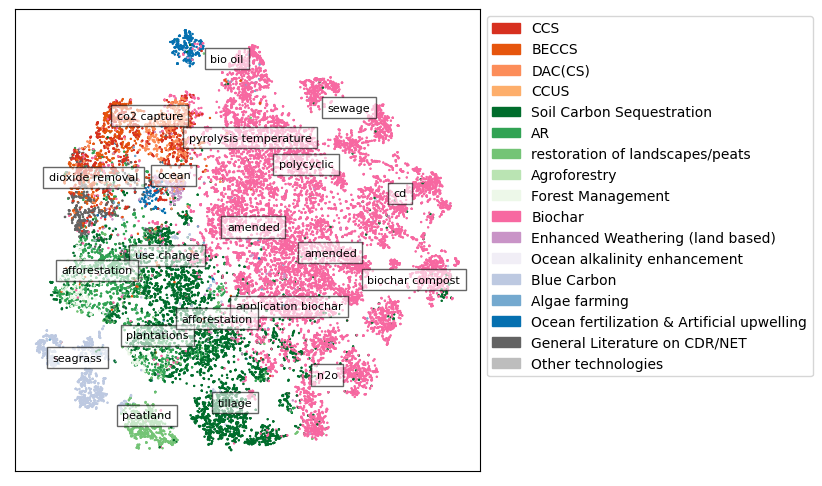

In [45]:
import matplotlib
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
scatter = ax.scatter(df.tsne_x, df.tsne_y, s=0.2, c=df.tech_color)

sizemap = {0: 1, 1: 10, 2: 10, 3: 20}
_ = ax.scatter(df.tsne_x, df.tsne_y, s=0.5, c=df.tech_color, rasterized=True)

#center_colors = list(map(colors.get, classes))
#ax.scatter(
#    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="black", s=48, alpha=1, edgecolor='k'
#)

# Draw mediod labels
for idx, label in enumerate(cluster_keywords):
    ax.text(
        kmeans.cluster_centers_[idx, 0],
        kmeans.cluster_centers_[idx, 1] + 2.2,
        label,
        fontsize=8,
        horizontalalignment="center",
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='black')
    )

# Hide ticks and axis
ax.set_xticks([]), ax.set_yticks([])#, ax.axis("off")

# legend
techs_con = df.first_pred_tech.unique().tolist()
#techs_goodOrder = [t for t in tech_goodOrder if t in techs_con]
legend_labels = []
for t in tech_goodOrder:
    legend_labels.append(mpatches.Patch(color=tc[t], label=t))
plt.legend(handles=legend_labels, bbox_to_anchor=(1,1))
fig.savefig("/home/sarah/projects/living_evidence/figures/all_map_labels.png", bbox_inches="tight", facecolor='white', edgecolor='none')

In [46]:

#tsne_x = np.array([xi for xi in dfs['tsne'].values])
kmeans = KMeans(n_clusters=20, random_state=0).fit(df_lessOrEq_2010[["tsne_x","tsne_y"]])
classes = np.unique(kmeans.labels_)
print(kmeans.labels_)
#print(kmeans.cluster_centers_)

cluster_titles = ['' for _ in classes]
for li, ll in enumerate(kmeans.labels_):
    tit = df_lessOrEq_2010.iloc[li]['title']
    if tit is not None:
        cluster_titles[ll] += tit

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3), min_df=1, max_df=0.6, strip_accents='ascii')
vectors = vectorizer.fit_transform(cluster_titles)
iv = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_keywords = [
    iv[kwi[0]]
    for kwi in vectors.argmax(axis=1).tolist()
]

[19 19 10 ... 13 13  6]


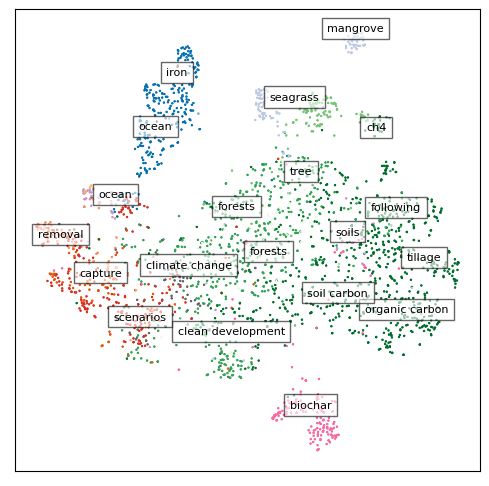

In [52]:
fig, ax = plt.subplots(figsize=(6,6))
scatter = ax.scatter(df_lessOrEq_2010.tsne_x, df_lessOrEq_2010.tsne_y, s=0.2, c=df_lessOrEq_2010.tech_color)

sizemap = {0: 1, 1: 10, 2: 10, 3: 20}
_ = ax.scatter(df_lessOrEq_2010.tsne_x, df_lessOrEq_2010.tsne_y, s=0.5, c=df_lessOrEq_2010.tech_color, rasterized=True)

#center_colors = list(map(colors.get, classes))
#ax.scatter(
#    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="black", s=48, alpha=1, edgecolor='k'
#)

# Draw mediod labels
for idx, label in enumerate(cluster_keywords):
    ax.text(
        kmeans.cluster_centers_[idx, 0],
        kmeans.cluster_centers_[idx, 1] + 2.2,
        label,
        fontsize=8,
        horizontalalignment="center",
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='black')
    )

# Hide ticks and axis
ax.set_xticks([]), ax.set_yticks([])#, ax.axis("off")

# legend
techs_con = df.first_pred_tech.unique().tolist()
#techs_goodOrder = [t for t in tech_goodOrder if t in techs_con]
legend_labels = []
for t in tech_goodOrder:
    legend_labels.append(mpatches.Patch(color=tc[t], label=t))
#plt.legend(handles=legend_labels, bbox_to_anchor=(1,1))
fig.savefig("/home/sarah/projects/living_evidence/figures/until2010_map_labels.png", bbox_inches="tight", facecolor='white', edgecolor='none')

### only one year difference

In [70]:
df_until2021 = df.loc[df.year<=2019]
vectorizer = TfidfVectorizer(stop_words='english') 
tfidf_text = vectorizer.fit_transform(df_until2021["title_abstract"])

pca = TruncatedSVD(n_components=50)
pca_result = pca.fit_transform(tfidf_text)
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
tsne_fit = tsne.fit(pca_result)

df_until2021["tsne_x"] = list(tsne_fit[:,0])
df_until2021["tsne_y"] = list(tsne_fit[:,1])

--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 2.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.21 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.10 seconds
===> Running optimization with exaggeration=12.00, lr=1282.92 for 250 iterations...
Iteration   50, KL divergence 5.2341, 50 iterations in 1.3569 sec
Iteration  100, KL divergence 5.0504, 50 iterations in 1.1026 sec
Iteration  150, KL divergence 5.0441, 50 iterations in 1.0471 sec
Iteration  200, KL divergence 5.0436, 50 iterations in 1.2210 sec
Iteration  250, KL divergence 5.0435, 50 iterations in 1.1642 sec
   --> Time elapsed: 5.89 seconds
===> Running optimization with exaggeration=1.00, lr=1282.92 for 500

/tmp/ipykernel_264195/3176532950.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_until2021["tsne_x"] = list(tsne_fit[:,0])
/tmp/ipykernel_264195/3176532950.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_until2021["tsne_y"] = list(tsne_fit[:,1])


In [72]:
#tsne_x = np.array([xi for xi in dfs['tsne'].values])
kmeans = KMeans(n_clusters=20, random_state=0).fit(df_until2021[["tsne_x","tsne_y"]])
classes = np.unique(kmeans.labels_)
print(kmeans.labels_)
#print(kmeans.cluster_centers_)

cluster_titles = ['' for _ in classes]
for li, ll in enumerate(kmeans.labels_):
    tit = df_until2021.iloc[li]['title']
    if tit is not None:
        cluster_titles[ll] += tit

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3), min_df=1, max_df=0.6, strip_accents='ascii')
vectors = vectorizer.fit_transform(cluster_titles)
iv = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_keywords = [
    iv[kwi[0]]
    for kwi in vectors.argmax(axis=1).tolist()
]

[17 16 17 ...  6 10  6]


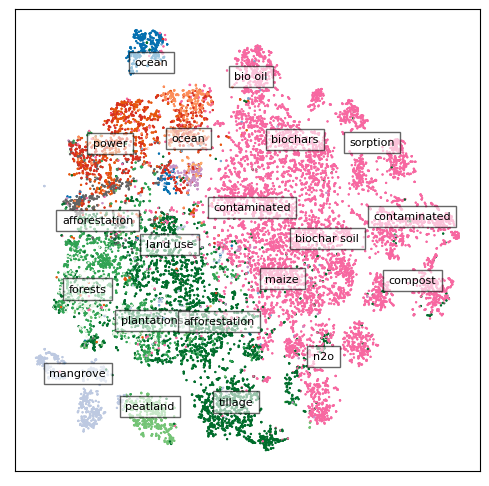

In [73]:
fig, ax = plt.subplots(figsize=(6,6))
scatter = ax.scatter(df_until2021.tsne_x, df_until2021.tsne_y, s=0.2, c=df_until2021.tech_color)

sizemap = {0: 1, 1: 10, 2: 10, 3: 20}
_ = ax.scatter(df_until2021.tsne_x, df_until2021.tsne_y, s=0.5, c=df_until2021.tech_color, rasterized=True)

#center_colors = list(map(colors.get, classes))
#ax.scatter(
#    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="black", s=48, alpha=1, edgecolor='k'
#)

# Draw mediod labels
for idx, label in enumerate(cluster_keywords):
    ax.text(
        kmeans.cluster_centers_[idx, 0],
        kmeans.cluster_centers_[idx, 1] + 2.2,
        label,
        fontsize=8,
        horizontalalignment="center",
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='black')
    )

# Hide ticks and axis
ax.set_xticks([]), ax.set_yticks([])#, ax.axis("off")

# legend
techs_con = df.first_pred_tech.unique().tolist()
#techs_goodOrder = [t for t in tech_goodOrder if t in techs_con]
legend_labels = []
for t in tech_goodOrder:
    legend_labels.append(mpatches.Patch(color=tc[t], label=t))
#plt.legend(handles=legend_labels, bbox_to_anchor=(1,1))
fig.savefig("/home/sarah/projects/living_evidence/figures/until2021_map_labels.png", bbox_inches="tight", facecolor='white', edgecolor='none')

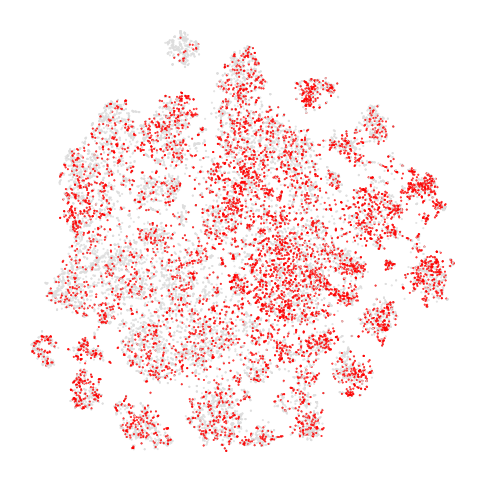

In [76]:
df["year_col"] = "#dddddd"
df.loc[df.year>2019,"year_col"] = "red"
df_first = df.loc[df.year<=2019].copy()
df_last = df.loc[df.year>=2019].copy()

fig, ax = plt.subplots(figsize=(6,6))
scatter = ax.scatter(df_first.tsne_x, df_first.tsne_y, s=0.2, c=df_first.year_col)
scatter = ax.scatter(df_last.tsne_x, df_last.tsne_y, s=0.2, c=df_last.year_col)

ax.axis('off')

# Hide ticks and axis
ax.set_xticks([]), ax.set_yticks([])#, ax.axis("off")

fig.savefig("/home/sarah/projects/living_evidence/figures/year_diff.png", bbox_inches="tight", facecolor='white', edgecolor='none')

In [69]:
df.year.value_counts()

2021.0    3617
2020.0    3119
2019.0    2551
2018.0    2245
2017.0    1802
2016.0    1577
2015.0    1269
2014.0    1133
2013.0     951
2012.0     713
2011.0     560
2010.0     451
2009.0     376
2008.0     282
2007.0     217
2006.0     190
2005.0     179
2004.0     160
2003.0     129
2002.0     105
2001.0      98
2000.0      89
1998.0      52
1999.0      50
1997.0      45
1996.0      39
1995.0      35
1993.0      27
1994.0      25
1992.0      24
1990.0      11
1991.0      10
2022.0       6
2023.0       5
Name: year, dtype: int64